# TERA - Aula 28
## Clustering

Objetivos gerais de algoritmos de clustering:
- Análise exploratória dos dados
- Encontrar padrões e estruturas
- Agrupar dados de forma a criar representações sumarizadas (sumarização de dados)

# Índice

- [Exemplo inicial](#Exemplo-Inicial)
- [K-Means](#K-Means)
 - [Case K-Means Elo7](#Case-Cluster-Usuários-Elo7)
- [Case Elo7 - Cluster Frete](#Case-Elo7---Clustering-de-Frete)
- [Hierarchical Clustering](#Hierarchical-Clustering)
 - [Exercício Prático](#Exercício-prático-Hierarchical-Clustering)
- [Case Elo7 - Motivos de Compra](#Case-Elo7---Motivos-de-Compra)

### Exemplo Inicial
Análise exploratória do comportamento dos usuários do Elo7.

Dataset:
- `tempo` (float): Tempo em segundos que um usuário permanece no site.
- `ticket` (float): Valor gasto em reais no site.

In [4]:
# Imports usados no curso
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

In [5]:
sns.set(style="ticks")
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('seaborn-colorblind')

In [6]:
# Pasta contendo os dados:
ROOT_FOLDER = os.path.realpath('..')
DATASET_FOLDER = os.path.join(ROOT_FOLDER,'datasets')

In [8]:
# Leitura dos dados
df_user_elo7 = pd.read_csv(os.path.join(DATASET_FOLDER, 'user_patterns_elo7_dataset.csv'), sep=';')

df_user_elo7.head(10)

,tempo,ticket
0,138.492732,63.029202
1,306.160891,75.160275
2,264.210040,74.064756
3,326.972183,95.059350
4,268.796360,47.015198
5,273.485755,62.461614
6,456.127583,48.683677
7,344.014574,63.391009
8,110.077589,80.916515
9,299.903768,44.419369


#### Análise Exploratória
- Média
- Covariância
- Tendência (Regressão Linear)

In [9]:
# Valor médio
user_elo7_mean = df_user_elo7.mean().values

# Covariância
user_elo7_cov = np.cov(df_user_elo7.values[:,0], df_user_elo7.values[:,1])

# Tendência - regressão
a, b, r, p, std_err = ss.linregress(df_user_elo7.values[:,0],df_user_elo7.values[:,1])
f = lambda x: a*x + b

In [10]:
print('- Média: {}'.format(user_elo7_mean))
print('- Covariância: \n{}'.format(user_elo7_cov))
print('- Coeficiente de correlação da regressão: {:.2f}'.format(r))

- Média: [718.41305716  95.82494287]
- Covariância: 
[[123372.18378516   6828.07629486]
 [  6828.07629486   1709.87352627]]
- Coeficiente de correlação da regressão: 0.47


Esses dados parecem interessantes, mas não são suficientes. Precisamos sempre observar os dados para tirar insights!

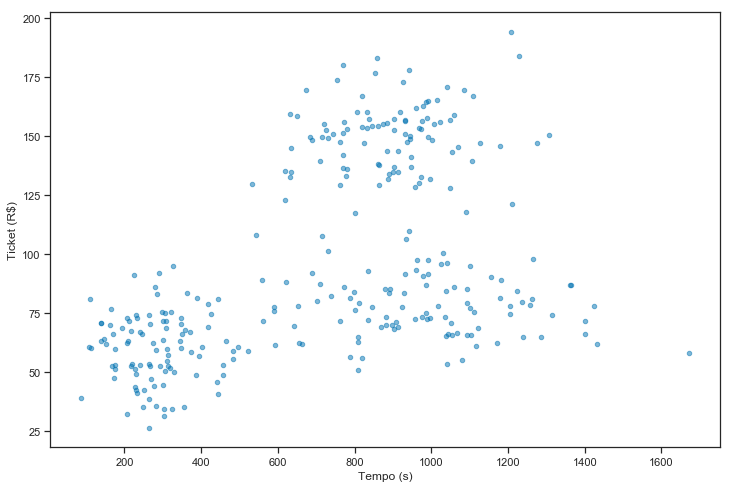

In [11]:
# Vamos plotar o gráfico
df_user_elo7.plot.scatter(x='tempo',y='ticket', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Ticket (R$)')
plt.show()

In [12]:
### Função auxiliar para plotar a elipse de confiança ###
from matplotlib.patches import Ellipse

def get_confidence_ellipse(x, y, nstd=2):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    cov = np.cov(x, y)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=w, height=h,
                  angle=theta, color='red', 
                  fill=False)
    return ell

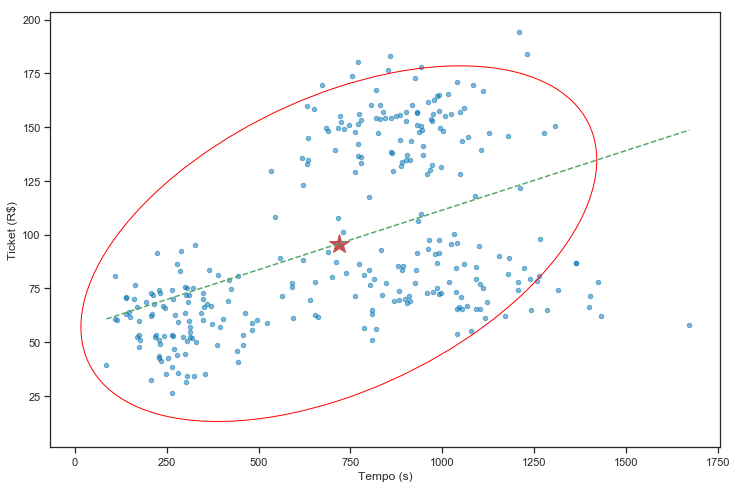

In [13]:
# Vamos plotar os dados no gráfico
df_user_elo7.plot.scatter(x='tempo',y='ticket', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Ticket (R$)')

# Média
plt.plot(user_elo7_mean[0], user_elo7_mean[1], '*r', markersize=20)

# 2 desvios padrão
ell = get_confidence_ellipse(x=df_user_elo7.values[:,0],
                             y=df_user_elo7.values[:,1])
ax = plt.gca()
ax.add_patch(ell)

# Tendência
x = np.array([min(df_user_elo7.values[:,0]),max(df_user_elo7.values[:,0])])
plt.plot(x, f(x), '--g')

plt.show()

Há algo estranho nessa análise?
- A análise está matematicamente correta, mas talvez não seja completa;
- Precisamos levar em consideração possíveis grupos diferentes de usuários dentro dos dados. Quantos grupos você vê? Talvez entre 2 e 4 clusters?

Vamos utilizar o famoso algoritmo [KMeans](https://en.wikipedia.org/wiki/K-means_clustering) para encontrar esses clusters. Podemos utilizar a implementação do [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) para isso.

---
## K-Means

In [16]:
# TODO
# Importe o módulo do KMeans
from sklearn.cluster import KMeans

# Crie uma instância do K-Means pelo sklearn
# Teste diferentes números de clusters
n = 3
kmeans = KMeans(n_clusters=n)

Agora podemos encontrar os clusters.

In [17]:
X = df_user_elo7.values

kmeans.fit(X)
labels = kmeans.labels_

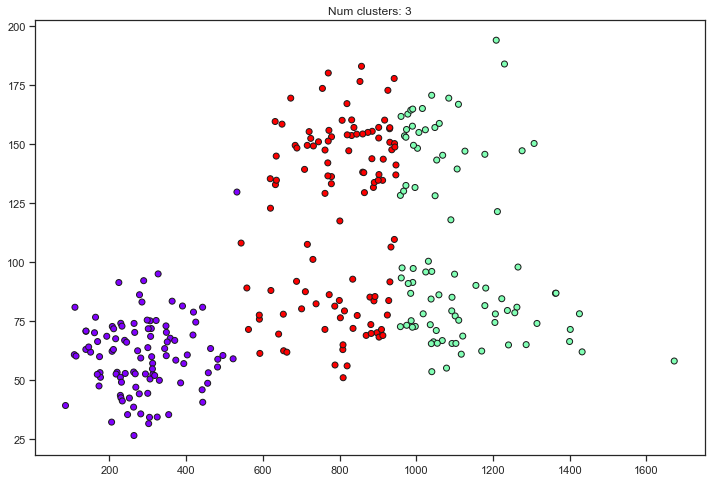

In [18]:
plt.scatter(x=df_user_elo7.values[:,0],
            y=df_user_elo7.values[:,1],
            c=labels.astype(np.float),
            cmap='rainbow',
            edgecolor='k')
plt.title('Num clusters: {}'.format(n))
plt.show()

Os clusters estão como esperado? Tem alguma hipótese do porque esses dados estão separados dessa forma?

---
A grande maioria dos algoritmos de aprendizado de máquina se baseiam na noção de distância entre pontos para encontrar relações entre os dados. Essa forma de tratar os problemas é bastante intuitiva e funciona em uma grande gama de cenários. Mas, existe um problema para calcularmos distâncias quando temos diversas variáveis com características diferentes. Para entender um pouco desse problema, note que as escalas dos eixos do gráfico anterior não são iguais. Veja como ficaria o gráfico se colocássemos os eixos com mesma escala:

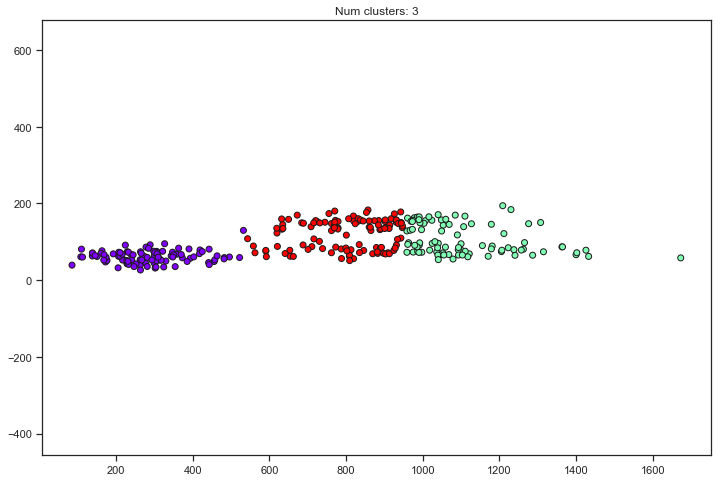

In [19]:
plt.scatter(x=df_user_elo7.values[:,0],
            y=df_user_elo7.values[:,1],
            c=labels.astype(np.float),
            cmap='rainbow',
            edgecolor='k')
plt.title('Num clusters: {}'.format(n))
plt.axis('equal')
plt.show()

Por isso devemos **normalizar** os dados! Essa etapa é muito importante e deve ser sempre considerada antes de executar algum algoritmo de aprendizado de máquina que se baseia em distâncias.

In [20]:
# Vamos normalizar os dados!
from sklearn.preprocessing import StandardScaler

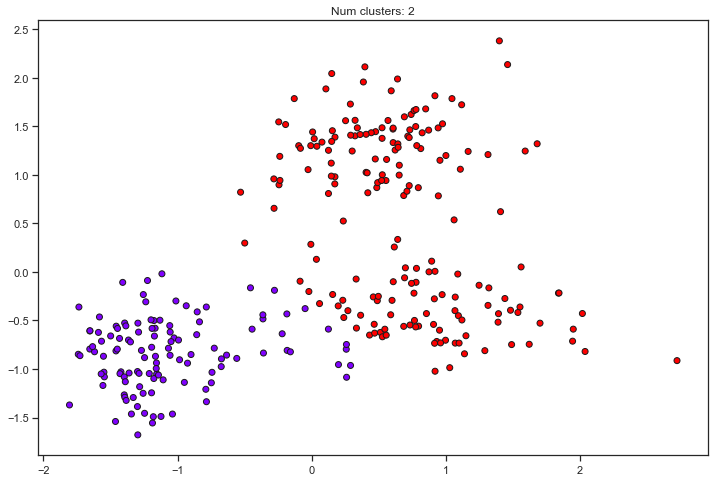

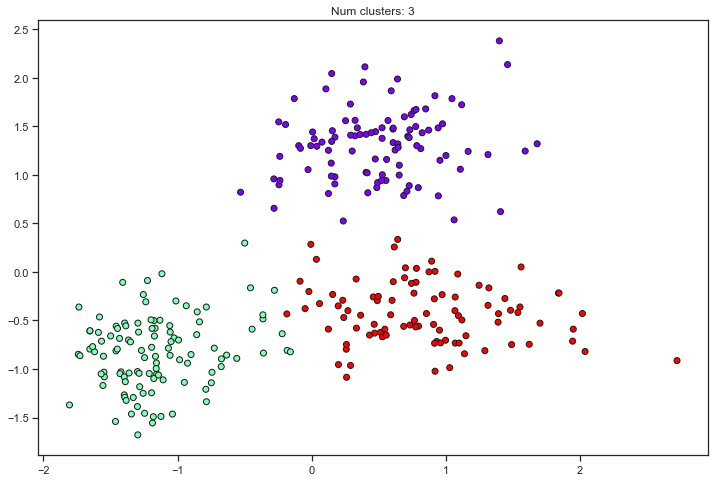

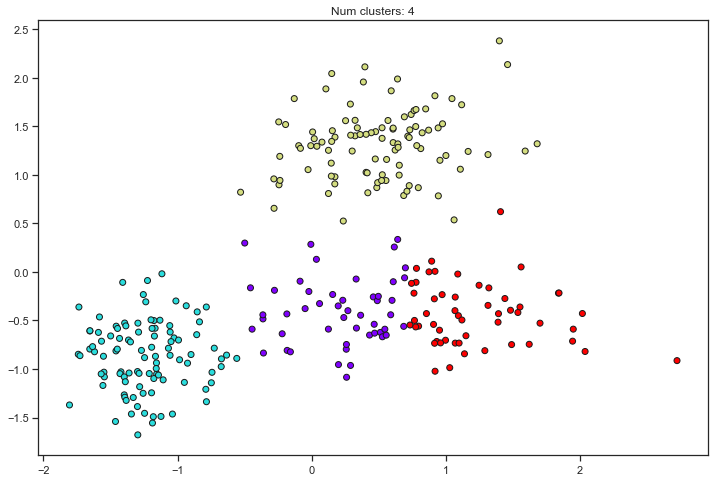

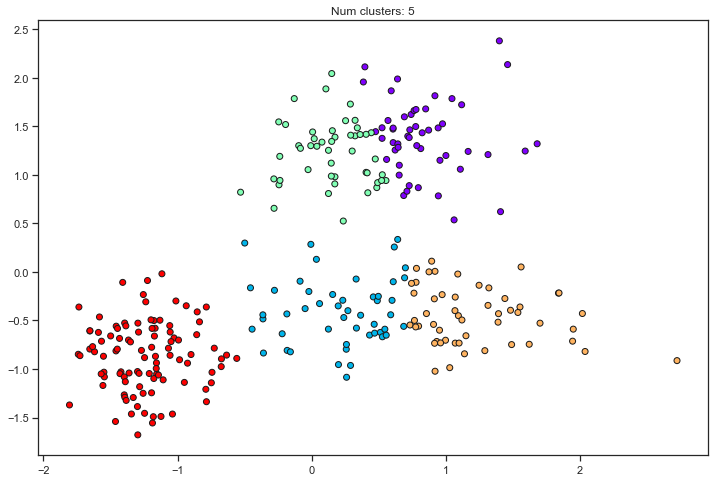

In [24]:
# E agora plotamos o resultado
n_clusters = range(2,6)

X = df_user_elo7.values

# Dados normalizados
X_scaled = StandardScaler().fit_transform(X)

for n in n_clusters:
    estimator = KMeans(n_clusters=n)
    estimator.fit(X_scaled)
    labels = estimator.labels_
    plt.scatter(x=X_scaled[:,0],
                y=X_scaled[:,1],
                c=labels.astype(np.float),
                cmap='rainbow',
                edgecolor='k')
    plt.title('Num clusters: {}'.format(n))
    plt.show()

Ok... podemos ver que podemos encontrar algumas opções de número de clusters, mas qual é o valor ideal?

#### Escolha do número de clusters

Nós temos diversos métodos para escolher o número ideal de clusters. Alguns deles estão resumidos neste [artigo](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_Elbow_Method). O método mais utilizado, entretanto, é o método do "cotovelo" (*elbow method*). 

Mas, antes de falarmos do método do cotovelo, nós precisamos definir o que é um bom cluster. É claro que isso depende de cada caso, mas as seguintes características são desejadas para a maioria dos clusters:
- Dados não muito dispersos -> Inércia
- Dados dentro dos clusters possuem perfil semelhante
- Quantidade aproximadamente uniforme de dados em cada cluster

#### Inércia

A inércia de um cluster é definida como a soma das distâncias quadráticas de cada ponto de um cluster ao seu respectivo centroide, somada através de todos os clusters. Quanto maior é a inércia, maior será a dispersão dos clusters. Portanto, desejamos escolher um número de clusters que nos possibilite ter uma inércia baixa. Simples, mas temos um problema... O mínimo valor de inércia que podemos obter é quando cada ponto do nosso dataset pertence ao seu próprio cluster. Portanto, precisamos escolher um balanço entre baixa inércia e baixo número de clusters. 

Para isso, utilizamos o gráfico de cotovelo. O eixo horizontal do gráfico representa o número de clusters utilizados e o eixo vertical representa a inércia total dos clusters. O número de clusters ideal é definido como o ponto onde o gráfico se aproxima a uma horizontal (como o ponto de encontro do braço e antebraço).

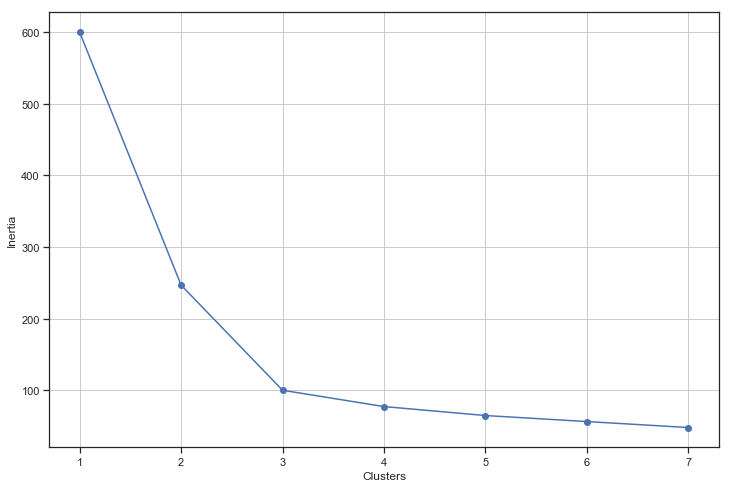

In [25]:
# Range de valores de clusters que vamos testar
k = range(1,8)

# Lista de inércias
inertias = []

# Para cada valor de k, ache a inércia
for i in k:
    # crie a instância
    kmeans = KMeans(n_clusters=i)

    # Treine o modelo
    model = kmeans.fit(X_scaled)

    # Ache a inercia dos clusters
    inertias.append(model.inertia_)
    
plt.plot(k, inertias, '-ob')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

Qual a sua opinião? Quantos clusters devemos utilizar?

In [ ]:
# TODO

---
## Case Elo7 - Clustering de Frete

Um dos problemas mais complicados do Elo7 é sua dependência dos correios. Nós sofremos muito com a falta de alternativas para dar aos nossos clientes (compradores e vendedores), já que o serviço dos correios além de caro, é também instável. 

Para tentar resolver esse problema, o time de Data Science do Elo7 foi chamado para tentar encontrar alguma alternativa. Após algumas conversas, nós levantamos a possibilidade de utilizarmos serviços de entrega independentes dos correios. Mas, o problema é que esses serviços necessitam de um volume grande de encomendas por ponto de coleta, o que não é o caso para a maioria dos vendedores cadastrados no Elo7. 

Uma possível solução seria encontrar pontos de coleta que pudessem agregar pedidos de vários vendedores e enviar de uma vez só com um desses serviços alternativos. Mas, como obtemos a localização desses pontos de coleta? Podemos aplicar um algoritmo de clustering nas rotas de frete mais frequentes!

Vamos tentar analisar os dados e verificar o que conseguimos obter. O dataset a seguir contém pares de endereços de origem e destino de entregas realizadas apenas na cidade de São Paulo em um curto intervalo de tempo.

In [26]:
df_route = pd.read_csv(os.path.join(DATASET_FOLDER, 'route_clustering_elo7_dataset.csv'), sep=';')

df_route.head()

,cep_origem,latitude_origem,longitude_origem,cep_destino,latitude_destino,longitude_destino
0,02854-000,-23.458472,-46.697457,05661-000,-23.608533,-46.729718
1,04563-000,-23.610779,-46.685776,05410-000,-23.557603,-46.676987
2,08265-000,-23.572392,-46.452325,02976-000,-23.481036,-46.715047
3,04195-000,-23.656972,-46.613229,03426-000,-23.552227,-46.537025
4,02235-000,-23.479388,-46.581890,05036-000,-23.516369,-46.690578


Para facilitar os cálculos de distância, as latitudes e longitudes dos locais já foram realizados.

Vamos agora formar nosso vetor de features contendo as posições geográficas das nossas rotas.

*Dica: Será que é necessário normalizar as features?

In [27]:
# TODO
X = df_route[['latitude_origem','longitude_origem','latitude_destino','longitude_destino']].values
X_scaled = StandardScaler().fit_transform(X)

In [28]:
X_scaled.shape

(4136, 4)

(-23.4, -23.9)

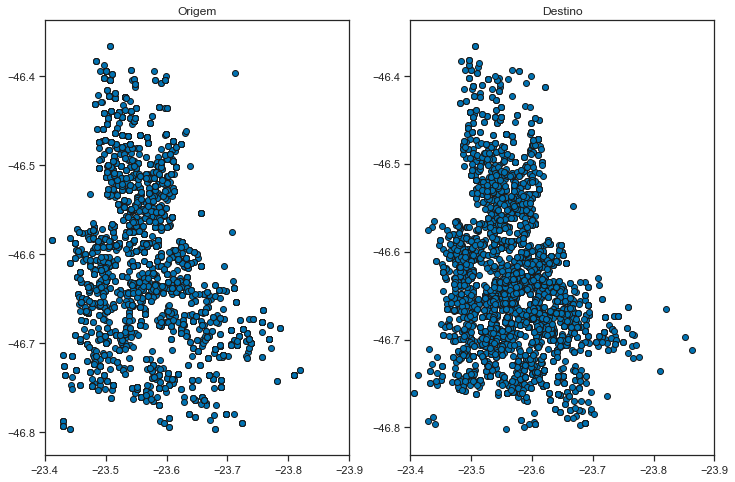

In [29]:
ax1 = plt.subplot(1,2,1)
ax1.set_title('Origem')
plt.scatter(x=X[:,0],
            y=X[:,1],
            edgecolor='k')
ax1.set_xlim((-23.4,-23.9))

ax2 = plt.subplot(1,2,2)
ax2.set_title('Destino')
plt.scatter(x=X[:,2],
            y=X[:,3], 
            edgecolor='k')
ax2.set_xlim((-23.4,-23.9))

Quantos clusters vamos utilizar? (Obs: Podemos aplicar o método do cotovelo para descobrir.)

In [ ]:
# TODO

Agora podemos iniciar o algoritmo de clustering.

In [55]:
# TODO
n = 20
kmeans = KMeans(n_clusters=n)

In [56]:
# TODO
clusters = kmeans.fit_predict(X_scaled)

A análise da quantidade de ítens em cada cluster é sempre uma boa prática. Clusters desbalanceados são um sinal de que os dados não foram bem separados.

In [57]:
cluster, count = np.unique(clusters, return_counts=True)
for l, c in zip(cluster,count):
    print('Cluster {}: {}'.format(l,c))

Cluster 0: 202
Cluster 1: 197
Cluster 2: 223
Cluster 3: 139
Cluster 4: 277
Cluster 5: 203
Cluster 6: 137
Cluster 7: 226
Cluster 8: 152
Cluster 9: 186
Cluster 10: 375
Cluster 11: 238
Cluster 12: 190
Cluster 13: 262
Cluster 14: 207
Cluster 15: 96
Cluster 16: 209
Cluster 17: 177
Cluster 18: 261
Cluster 19: 179


Vamos ver os gráficos para analisar qualitativamente os resultados.

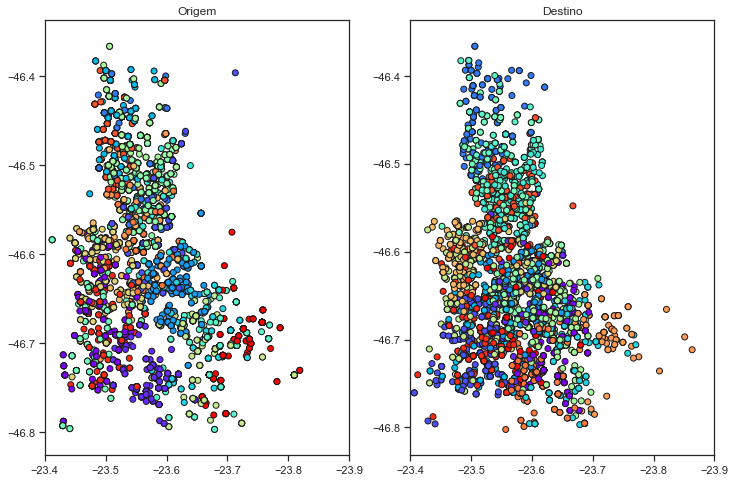

In [58]:
labels = kmeans.labels_

ax1 = plt.subplot(1,2,1)
ax1.set_title('Origem')
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=labels, 
            edgecolor='k',
            cmap='rainbow')
ax1.set_xlim((-23.4,-23.9))

ax2 = plt.subplot(1,2,2)
ax2.set_title('Destino')
plt.scatter(x=X[:,2],
            y=X[:,3],
            c=labels, 
            edgecolor='k',
            cmap='rainbow')
ax2.set_xlim((-23.4,-23.9))

plt.show()

O que achou? É possível perceber clusters bem definidos? Será que podemos utilizar esses clusters para resolver nossos problemas de frete?

---
### Exemplo Prático - Kaggle NYC Taxi Trip Duration

Dados:
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

![iris](https://cdn.civitatis.com/estados-unidos/nueva-york/galeria/thumbs/taxi-nueva-york.jpg)

*Solução retirada do github de [juifa-tsai](https://github.com/juifa-tsai/NYC_Taxi_Trip_Duration).

Vamos realizar uma análise dos dados.

In [59]:
df_taxi = pd.read_csv(os.path.join(DATASET_FOLDER,'nyc_trip_duration_dataset.csv'))

In [60]:
df_taxi.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id3070488,1,2016-05-10 09:36:01,2016-05-10 09:51:36,1,-73.960396,40.773849,-73.982414,40.775364,N,935
1,id3797315,1,2016-05-30 00:29:32,2016-05-30 00:34:08,1,-73.999039,40.734386,-74.007629,40.741051,N,276
2,id2982351,1,2016-02-13 22:03:12,2016-02-13 22:13:08,2,-74.012695,40.701694,-74.011086,40.729237,N,596
3,id0576937,2,2016-05-15 00:19:30,2016-05-15 00:39:14,1,-73.950188,40.783958,-73.867882,40.845356,N,1184
4,id3672156,1,2016-01-20 08:59:47,2016-01-20 09:18:15,1,-74.001541,40.746754,-73.978409,40.750282,N,1108


Podemos utilizar diversas abordagens para analisar os dados. Vamos tentar verificar os dados de localização dos passageiros.

In [61]:
df_map = df_taxi[['pickup_longitude','pickup_latitude', 'dropoff_longitude','dropoff_latitude']]
df_pick = df_map[['pickup_longitude','pickup_latitude']]
df_drop = df_map[['dropoff_longitude','dropoff_latitude']]

Vamos visualizar os dados.

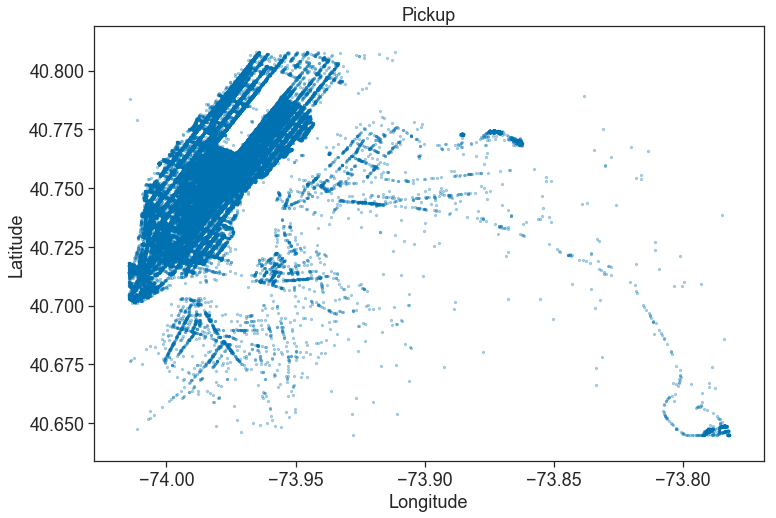

In [62]:

def plot_map(df, zoom=0.9):
    cutmap = zoom/100

    x = df['pickup_longitude']
    y = df['pickup_latitude']
    x_max, x_min = x.quantile(1-cutmap), x.quantile(cutmap)
    y_max, y_min = y.quantile(1-cutmap), y.quantile(cutmap)
    
    x_plot = x[(x>x_min) & (x<x_max) & (y<y_max) & (y>y_min)]
    y_plot = y[(x>x_min) & (x<x_max) & (y<y_max) & (y>y_min)]
    plt.scatter(x=x_plot, y=y_plot, s=5, alpha=0.3)
    plt.tick_params(labelsize=18)
    plt.title('Pickup', fontsize=18 )
    plt.xlabel('Longitude', fontsize=18)
    plt.ylabel('Latitude',  fontsize=18)
    plt.show()

plot_map(df_taxi)

A distribuição dos dados é bem interessante. Podemos verificar que existe uma concentração grande de pontos dentro da ilha de Manhattan, o que é esperado.

Como segundo passo da análise dos dados, nós podemos tentar enriquecê-los utilizando técnicas de feature engineering e clustering. Vamos explorar o segundo em seguida.

O racional de utilizar clustering para análise exploratória e feature engineering é o fato de encontrar estruturas implícitas nos dados. Por exemplo, se tentássemos observar cada passageiro individualmente, talvez teríamos dificuldade em encontrar um padrão nos dados. Mas, é intuitivo pensar que passageiros semelhantes (mesma localização, horário etc) possam ser agrupados e tratados como um só. Assim, podemos tratar os dados por grupos controlados de passageiros, ao invés de cada indivíduo.

Vamos tentar encontrar clusters nos dados de início da corrida de taxi.

In [63]:
kmeans = KMeans(n_clusters=20)

In [64]:
X_kmeans = kmeans.fit_predict(df_pick)
df_pick['zone']  = X_kmeans

C:\Users\Raphael Ballet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


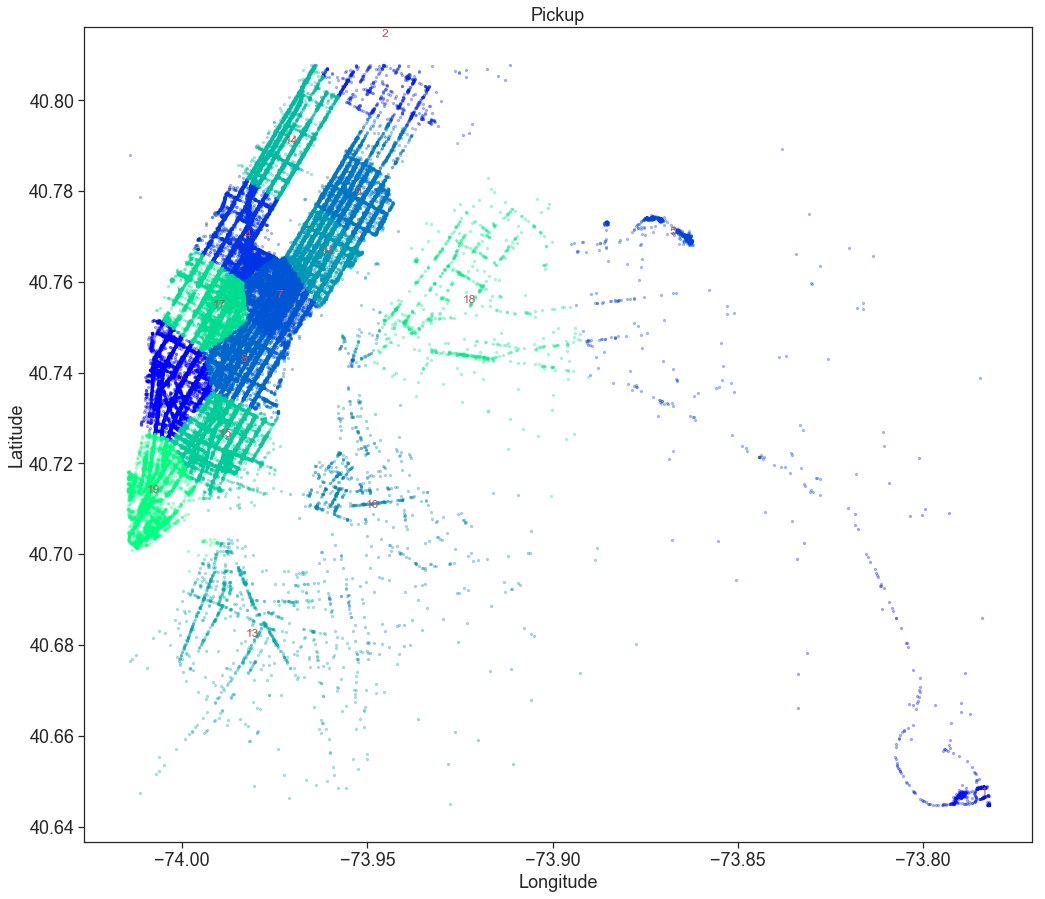

In [65]:
def draw_map_zone( df, x_name, y_name, z_name, name, zoom=0.9, cluster=None ):

    x = df[x_name]
    y = df[y_name]
    z = df[z_name]

    cutmap = zoom/100
    x_max, x_min = x.quantile(1-cutmap), x.quantile(cutmap)
    y_max, y_min = y.quantile(1-cutmap), y.quantile(cutmap)
    
    zones = np.unique(z[(x>x_min) & (x<x_max) & (y<y_max) & (y>y_min)])

    #cmap = plt.get_cmap('spectral') 
    cmap = plt.get_cmap('winter') 
    colors = [cmap(i) for i in np.linspace(0, 1, len(zones))]

    for i, zone in enumerate(zones):       
        plt.scatter( x=x[ (z==zone) & (x>x_min) & (x<x_max) & (y<y_max) & (y>y_min) ], 
                     y=y[ (z==zone) & (x>x_min) & (x<x_max) & (y<y_max) & (y>y_min) ], 
                     s=5, alpha=0.3, c=colors[i])
        if cluster:
            plt.text( cluster.cluster_centers_[zone,0], cluster.cluster_centers_[zone,1], str(zone), fontsize = 12, color='r')

    plt.tick_params(labelsize=18)
    plt.title(name, fontsize=18 )
    plt.xlabel('Longitude', fontsize=18)
    plt.ylabel('Latitude',  fontsize=18)


plt.figure(figsize=(17,15))
draw_map_zone(df_pick, 'pickup_longitude', 'pickup_latitude', 'zone', 'Pickup', cluster=kmeans)
plt.show()

Não por acaso, os clusters encontrados se assemelham aos bairros de Nova Iorque. Esses clusters agora podem ser utilizados de diversas formas:
- Podemos explorar a distribuição das outras features dentro de cada um dos clusters. Assim poderemos ver o quanto cada região se diferença das outras.
- Podemos também utilizar agora as labels obtidas pelo algoritmo de clustering como entrada de outros algoritmos de machine learning. Essa técnica é muito utilizada para melhorar a precisão dos algoritmos de regressão e classificação.

Vamos tentar utilizar clustering na solução encontrada na [aula 19](https://github.com/somostera/data-science-abril-19/blob/master/19-decision-trees/notebooks/Gabarito%20%C3%81rvores%20de%20Decis%C3%A3o.ipynb) para verificar se conseguimos aumentar a precisão do regressor.

In [66]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold

In [71]:
df_map.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,-73.960396,40.773849,-73.982414,40.775364
1,-73.999039,40.734386,-74.007629,40.741051
2,-74.012695,40.701694,-74.011086,40.729237
3,-73.950188,40.783958,-73.867882,40.845356
4,-74.001541,40.746754,-73.978409,40.750282


In [75]:
df_taxi_cluster.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,zone
0,id3070488,1,2016-05-10 09:36:01,2016-05-10 09:51:36,1,-73.960396,40.773849,-73.982414,40.775364,N,935,34
1,id3797315,1,2016-05-30 00:29:32,2016-05-30 00:34:08,1,-73.999039,40.734386,-74.007629,40.741051,N,276,54
2,id2982351,1,2016-02-13 22:03:12,2016-02-13 22:13:08,2,-74.012695,40.701694,-74.011086,40.729237,N,596,83
3,id0576937,2,2016-05-15 00:19:30,2016-05-15 00:39:14,1,-73.950188,40.783958,-73.867882,40.845356,N,1184,85
4,id3672156,1,2016-01-20 08:59:47,2016-01-20 09:18:15,1,-74.001541,40.746754,-73.978409,40.750282,N,1108,38


In [67]:
kfold = KFold(n_splits=5,random_state=0)

df_taxi_cluster = df_taxi.copy()

kmeans = KMeans(n_clusters=100)
X_kmeans = kmeans.fit_predict(df_map)
df_taxi_cluster['zone'] = X_kmeans

x = df_taxi.drop(['trip_duration', 'id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'], axis=1)
y = df_taxi['trip_duration']

x_cluster = df_taxi_cluster.drop(['trip_duration', 'id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'], axis=1)

reg = DecisionTreeRegressor()

In [68]:
def make_cv_prediction(x,y,train_index,test_index,reg):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    return y_pred, y_test

def rmsle(y_test, y_pred):
    return np.sqrt(mean_squared_log_error(y_test,y_pred))

rmsle_cv_default = []
rmsle_cv_cluster = []
for train_index, test_index in kfold.split(x,y):
    y_pred, y_test = make_cv_prediction(x,y,train_index,test_index,reg)
    rmsle_cv_default.append(rmsle(y_test, y_pred))
    
    y_pred_cluster, y_test = make_cv_prediction(x_cluster,y,train_index,test_index,reg)
    rmsle_cv_cluster.append(rmsle(y_test, y_pred_cluster))

In [69]:
print('Default: {:.4f}'.format(np.mean(rmsle_cv_default)))
print('Cluster: {:.4f}'.format(np.mean(rmsle_cv_cluster)))

Default: 0.6827
Cluster: 0.6684


Pode-se notar um ligeiro aumento de precisão do estimador ao utilizar o cluster.

---
## Hierarchical Clustering

Vamos agora aprender sobre outro método de clustering: [**Hierarchical Clustering**](https://en.wikipedia.org/wiki/Hierarchical_clustering). Como o nome mesmo diz, ele utiliza o conceito de *hierarquia* para construir os clusters. Existem duas principais variações do algoritmo: aglomerativo e por divisão. O primeiro é mais usado na prática. O passo a passo do algoritmo é apresentado abaixo:

- Primeiro colocamos todos as observações em clusters próprios (individuais);
- Depois, iterativamente procuramos os clusters mais próximos\* e agrupamos eles em um novo cluster;
- Repetimos o passo anterior até formarmos um único cluster com todas as observações.

\*Obs: A definição de distância (ou similaridade) entre clusters depende do tipo de métrica de distância (Euclidiana, Manhattan, cosseno etc) e ligação (Ward, simples, completa etc).

Como podemos ver no algoritmo, o objetivo é a criação de um grande cluster que agrupe todos os dados. Nós podemos visualizar esse histórico de agrupamentos a partir de um [dendrograma](https://en.wikipedia.org/wiki/Dendrogram). A então criação de clusters mais granulares depende da região de similaridade que se deseja realizar o corte.

Vamos aplicar o método de Hierarchical Clustering no dataset de usuários do Elo7.

In [76]:
from sklearn.preprocessing import StandardScaler

df_user_elo7 = pd.read_csv(os.path.join(DATASET_FOLDER, 'user_patterns_elo7_dataset.csv'), sep=';')

X = df_user_elo7.values

# Dados normalizados
X_scaled = StandardScaler().fit_transform(X)

In [77]:
# Importe os métodos linkage (Hierarchical Clustering) e dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

O scikit-learn possui um método próprio para o algoritmo de [Hierarchical Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering). Entretanto, ele não nos permite visualizar facilmente o dendrograma final. Por isso, vamos utilizar a versão do scipy.

In [114]:
# TODO
# Vamos escolher a métrica de distância:
distance = 'euclidean' # 'euclidean'|'cityblock'|'cosine'...
# Agora o tipo de ligação
linkage_type = 'ward' # 'single'|'complete'|'average'|'ward'...

# Vamos aplicar o método linkage
Y = linkage(X_scaled, method=linkage_type, metric=distance)

In [115]:
Y.shape

(299, 4)

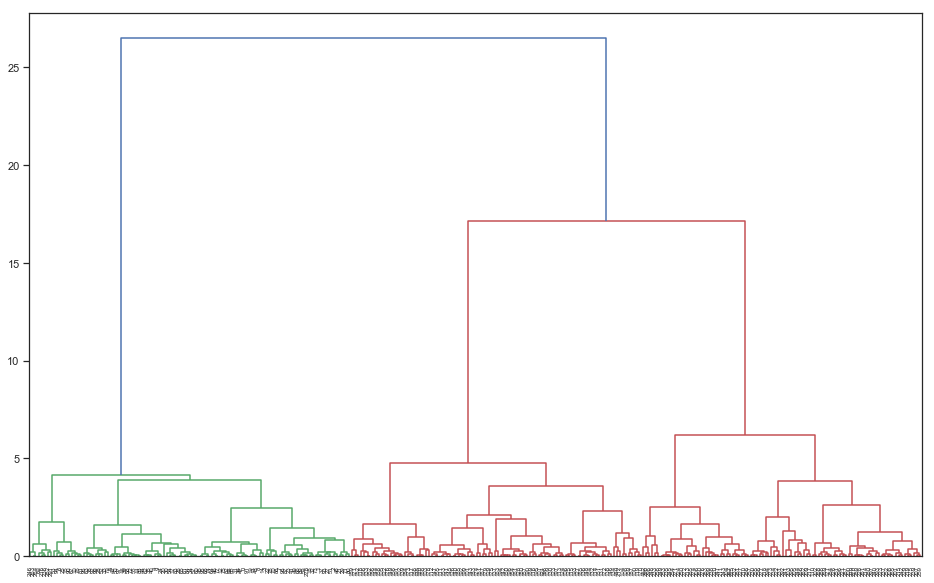

In [116]:
# Vamos visualizar o dendrograma
plt.figure(figsize=(16,10))
dendrogram(Y,
           leaf_rotation=90,
           leaf_font_size=6,
)
plt.show()

O que achou? Teste outros valores de distância e tipo de ligação para verificar as diferenças nos resultados!

O dendrograma nos permite verificar qual é o número de clusters que vamos escolher ao final. Além disso, podemos verificar se a distância e o tipo de ligação foram bem escolhidos.

O que precisamos fazer agora é escolher o número de clusters. Podemos utilizar o mesmo método do cotovelo para esse objetivo, mas, na prática, podemos apenas visualizar qual é a região que possui maior distância entre aglutinações. Outros trabalhos ainda utilizam um coeficiente de [Correlação Cofenética](https://en.wikipedia.org/wiki/Cophenetic_correlation) para encontrar uma boa posição de corte no dendrograma.

Para essa tarefa nós podemos usar o método [`fcluster`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.fcluster.html) do scipy. Ele nos permite realizar um corte na árvore de clustering gerada pelo Hierarchical Clustering.

In [117]:
from scipy.cluster.hierarchy import fcluster

In [124]:
# TODO
# Vamos gerar os rótulos para os clustes
num_clusters = 3 # escolha o número de clusters que deseja
labels = fcluster(Y, num_clusters ,criterion='maxclust')

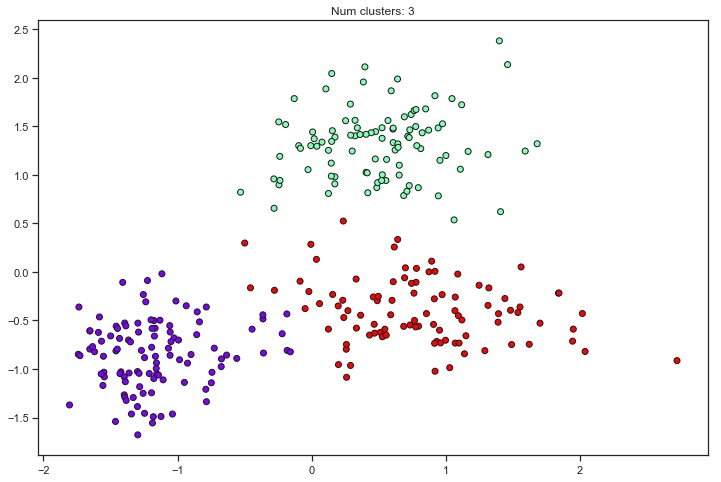

In [125]:
plt.scatter(x=X_scaled[:,0],
            y=X_scaled[:,1],
            c=labels.astype(np.float),
            cmap='rainbow',
            edgecolor='k')
plt.title('Num clusters: {}'.format(num_clusters))
plt.show()

---
## Case Elo7 - Clustering de Frete

Vamos tentar aplicar o mesmo algoritmo para o problema de cluster de frete.

In [128]:
df_route = pd.read_csv(os.path.join(DATASET_FOLDER, 'route_clustering_elo7_dataset.csv'), sep=';')

df_route.head()

,cep_origem,latitude_origem,longitude_origem,cep_destino,latitude_destino,longitude_destino
0,02854-000,-23.458472,-46.697457,05661-000,-23.608533,-46.729718
1,04563-000,-23.610779,-46.685776,05410-000,-23.557603,-46.676987
2,08265-000,-23.572392,-46.452325,02976-000,-23.481036,-46.715047
3,04195-000,-23.656972,-46.613229,03426-000,-23.552227,-46.537025
4,02235-000,-23.479388,-46.581890,05036-000,-23.516369,-46.690578


In [129]:
X = df_route[['latitude_origem','longitude_origem','latitude_destino','longitude_destino']].values
X_scaled = StandardScaler().fit_transform(X)

In [138]:
# TODO
# Vamos escolher a métrica de distância:
distance = 'euclidean'
# Agora o tipo de ligação
linkage_type = 'ward'

# Vamos aplicar o método linkage
Y = linkage(X_scaled, method=linkage_type, metric=distance)

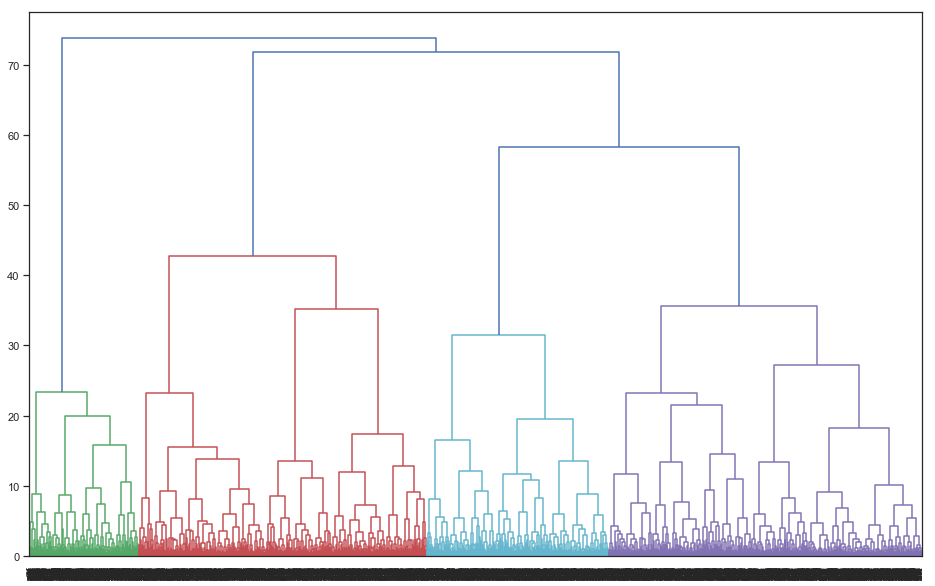

In [139]:
# Vamos visualizar o dendrograma
plt.figure(figsize=(16,10))
dendrogram(Y,
           leaf_rotation=90,
           leaf_font_size=6,
)
plt.show()

In [140]:
# TODO
# Vamos gerar os rótulos para os clustes
num_clusters = 4
labels = fcluster(Y, num_clusters ,criterion='maxclust')

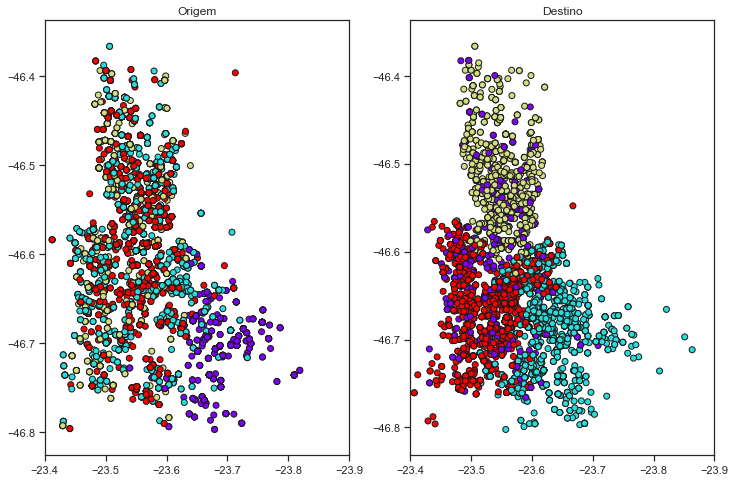

In [141]:
ax1 = plt.subplot(1,2,1)
ax1.set_title('Origem')
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=labels, 
            edgecolor='k',
            cmap='rainbow')
ax1.set_xlim((-23.4,-23.9))

ax2 = plt.subplot(1,2,2)
ax2.set_title('Destino')
plt.scatter(x=X[:,2],
            y=X[:,3],
            c=labels, 
            edgecolor='k',
            cmap='rainbow')
ax2.set_xlim((-23.4,-23.9))

plt.show()

---
# Case Elo7 - Motivos de Compra

Os compradores do Elo7 são incentivados a indicar o motivo da compra de determinado produto no seu marketplace. Esses motivos nos ajudam a entender melhor o **momento** de compra do usuário. O dataset apresentado a seguir contém um subset desses motivos de compra.

In [142]:
df_reason = pd.read_csv(os.path.join(DATASET_FOLDER, 'purchase_reason_elo7_dataset.csv'), sep=';')

df_reason.head(10)

,product_title,reason
0,apliques recortados fundo do mar,festa de 2 anos do meu filho
1,mini raposa vermelha amigurumi,presente para mim
2,o pequeno principe i bata,aniversario
3,quadro maternidade menino elefante,nascimento do meu bebe
4,livro de votos casamento o par,casamento
5,caixa 40 charuto de chocolate belga,lembranca de maternidade
6,arquivo de corte vamos brindar,mimo para mim
7,prateleira com varao mdf reta 96x20x14,decoracao do quarto da minha filha
8,colherzinha bailarina,aniversario
9,caixa cone arvore jardim dos passarinhos,festa


Existem muitos tipos possíveis de motivos de compra, mas será que nós podemos encontrar algum padrão neles? Me parece um problema clássico de **clustering**.

Vamos utilizar o Tf-Idf para criar o embedding dos motivos de compra e o K-Means para encontrar clusters.

In [143]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.9, max_features=5000, sublinear_tf=True, use_idf=True)

Cria a matriz de embeddings.

In [144]:
X = tfidf.fit_transform(df_reason['reason'].values)

Como escolher o número de clusters? Vamos utilizar o gráfico de inércias. (Obs: outra possibilidade é avaliar o ["silhouette score"](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)).

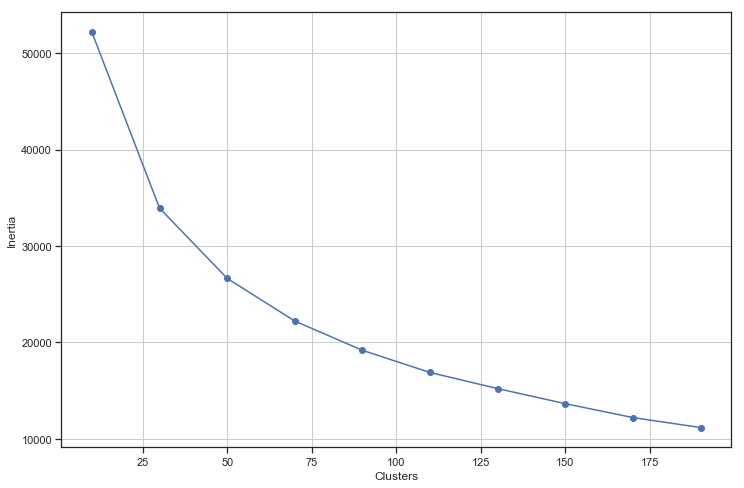

In [152]:
# Range de valores de clusters que vamos testar
k = range(10,200,20)

# Lista de inércias
inertias = []

# Para cada valor de k, ache a inércia
for i in k:
    # crie a instância
    kmeans = KMeans(n_clusters=i)

    # Treine o modelo
    model = kmeans.fit(X)

    # Ache a inercia dos clusters
    inertias.append(model.inertia_)
    
plt.plot(k, inertias, '-ob')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

Inicializa o K-Means com a quantidade de clusters que escolhemos a partir do gráfico.

In [153]:
# TODO
n = 50
kmeans = KMeans(n_clusters=n)

Treine o modelo K-Means.

In [154]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Encontra os clusters para cada motivo de compra.

In [155]:
# TODO
labels = kmeans.predict(X)

Vamos agora visualizar os clusters criados.

In [156]:
# Crie um novo dataframe com os labels dos clusters
df = pd.DataFrame({'reason': df_reason['reason'], 'labels': labels})

df.head()

,reason,labels
0,festa de 2 anos do meu filho,31
1,presente para mim,14
2,aniversario,6
3,nascimento do meu bebe,30
4,casamento,3


Vamos verificar a distribuição de motivos em cada cluster. Quanto mais desbalanceado, pior.

In [157]:
df.groupby('labels').size()

labels
0      1590
1      6967
2       785
3      6260
4      1281
5      6412
6      8874
7       329
8      2082
9     10723
10     1294
11     1428
12     1760
13     1457
14     2423
15     1365
16     2148
17     2748
18     1684
19     2016
20      740
21      123
22     1960
23      551
24      108
25     1377
26     1311
27     1797
28     1957
29     2367
30      936
31     5959
32      674
33      900
34      437
35      598
36     1281
37      659
38     1830
39      462
40     1739
41     1044
42     1394
43     1912
44      810
45      542
46      662
47      565
48     1066
49      613
dtype: int64

Podemos visualizar alguns exemplos de clusters gerados pelo K-Means.

In [158]:
for idx in range(50):
    idx_labels = df[df['labels']==idx]['reason'].unique()
    print('- Cluster {}:'.format(idx + 1))
    for i in np.random.choice(idx_labels, min(len(idx_labels), 10), replace=False):
        print(' '*5, i)
    print()

- Cluster 1:
      quarto da minha princesa
      presente minha princesa
      pra minha princesa
      para o quarto da minha princesa
      decoracao para o quarto da minha princesa
      para o aniversario da minha princesa
      aniversario da minha princesa
      lembrancinhas da minha princesa
      mimos para minha princesa
      presente para o quarto da minha princesa

- Cluster 2:
      presente de aniversario da minha filha
      convite para o aniversario da minha filha
      chegada da minha filha
      quartinho da minha filha
      cha da minha filha
      lembrancinha do aniversario da minha filha
      lembrancas do aniversario da minha filha
      lembranca aniversario da minha filha
      vestido para o aniversario da minha filha
      para festa da minha filha

- Cluster 3:
      aniversario do meu pequeno
      decoracao do quarto do meu baby
      aniversario do neto
      festa do meu afilhado
      niver do meu neto
      convites do meu casamento
      anivers

Qual é o resultado dos clusters gerados? Podemos avançar um pouco e verificar se existe alguma relação de hierarquia entre os motivos de compra.

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# TODO
Y = linkage(_, method='', metric='')

In [ ]:
# Obtém aleatoriamente um dos motivos para representar o cluster
titles = df.groupby('labels').apply(lambda x: np.random.choice(list(x['reason'])))

In [ ]:
# plota o dendrograma
plt.figure(figsize=(16,10))
dendrogram(Y,
           labels=titles.values,
           leaf_rotation=90,
           leaf_font_size=14,
)
plt.show()

Qual foi o resultado? O que você faria para melhorar o resultado obtido?

---
# Case Elo7 - Subcategorias Automáticas

Vamos para mais um case real do Elo7!

Esse case é um dos trabalhos mais recentes do time de Data Science do Elo7. De fato, é um trabalho ainda em aberto e qualquer sugestão de melhorias é bem vinda! =)

- O problema:
O Elo7 possui uma árvore de categorias dividida em N1 e N2. O primeiro nível (N1) contém as categorias "alto nível" do site. São as categorias mais genéricas do marketplace- ou, pelo menos, é assim gostaríamos que fosse. As categorias N2, ou subcategorias, são as possíveis extensões dos nós das categorias N1. Podemos perceber que a árvore é extremamente limitada e isso é um problema grave não só para os compradores, que não conseguem navegar nas nossas categorias, mas também para os vendedores, que não conseguem categorizar bem seus produtos. A solução para esse problema seria uma árvore de categorias com maior "granularidade", ou seja, que consiga expandir além dos 2 níveis e ter mais subcategorias.

- O que o time de Data Science tem a ver com essa história? 

Bom, gerar uma nova árvore de categoria pode ser uma tarefa bastante monótona e cansativa. Provavelmente deve haver algum jeito de encontrar bons agrupamentos de produtos que pudessem servir como uma nova subcategoria. Talvez algum método de clustering que utilize como features o conteúdo dos produtos pode gerar algum resultado interessante.

- O experimento:

O dataset a seguir possui um subconjunto de produtos que foram categorizados na categoria N1 "Casamento". Escolhemos esse conjunto de dados para iniciar nossos trabalhos, porque assim temos mais controle sobre nossos resultados. E, também, porque é uma das categorias mais importantes do marketplace.

Para essa tarefa, vamos utilizar apenas o título e uma parte da descrição do produto (aprox. 140 caracteres) como features de entrada.

Vamos analisar os dados!

In [ ]:
df_cat = pd.read_csv(os.path.join(DATASET_FOLDER, 'subcategory_elo7_dataset.csv'), sep=';')

df_cat.head(10)

Vamos criar uma coluna com as features que vamos incluir no nosso modelo de aprendizagem.
Esse vetor de features será o título + descrição do produto. Para compensar a quantidade de palavras do título em relação a descrição, vamos repetir o título duas vezes.

In [ ]:
df_cat['title_desc'] = (df_cat['title'] + ' ')*2 + df_cat['short_description']

df_cat.head(10)

Tente encontrar as subcategorias dos produtos da categoria "casamento". Lembre-se de que não queremos apenas aumentar o número de subcategorias do segundo nível (N2), mas também aumentar a profundidade da nossa árvore de categorias (N3, N4 ...).

Para criar nossa matriz de features, nós vamos utilizar o Tf-Idf.

In [ ]:
tfidf = TfidfVectorizer(max_df=0.9, max_features=10000, sublinear_tf=True, use_idf=True)

In [ ]:
X = tfidf.fit_transform(df_cat['title_desc'].values)

Novamente, precisamos definir o número de clusters. Podemos utilizar o método do gráfico de inércias.

(Obs: O cálculo pode levar muito tempo para ser executado. Assuma que o valor escolhido é 40)

In [ ]:
# Range de valores de clusters que vamos testar
k = range(10,100,10)

# Lista de inércias
inertias = []

# Para cada valor de k, ache a inércia
for i in k:
    # crie a instância
    kmeans = KMeans(n_clusters=i)

    # Treine o modelo
    model = kmeans.fit(X)

    # Ache a inercia dos clusters
    inertias.append(model.inertia_)
    
plt.plot(k, inertias, '-ob')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [ ]:
# TODO
kmeans = _

In [ ]:
# TODO
labels = _

In [ ]:
df = pd.DataFrame({'title': df_cat['title'], 'labels': labels})

In [ ]:
df.groupby('labels').size()

In [ ]:
for idx in range(len(df['labels'].unique())):
    idx_labels = df[df['labels']==idx]['title'].unique()
    print('- Cluster {}:'.format(idx + 1))
    for i in np.random.choice(idx_labels, min(len(idx_labels), 10), replace=False):
        print(' '*5, i)
    print()

In [ ]:
# TODO
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Y = linkage(_, method=_, metric=_)

In [ ]:
titles = df.groupby('labels').apply(lambda x: np.random.choice(list(x['title'])))

In [ ]:
plt.figure(figsize=(16,10))
dendrogram(Y,
           labels=titles.values,
           leaf_rotation=90,
           leaf_font_size=14,
)
plt.show()